<a href="https://colab.research.google.com/github/Jinyong-20/Machine_Learning_Programming/blob/master/lesson6_rossmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [0]:
from fastai.tabular import *

\# 드라이브 마운트, 자동 리로드, 함수 임포트

# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [0]:
path =  Config().data_path()/'rossmann/'
path.mkdir(parents=True, exist_ok=True)

In [0]:
! cp '/content/gdrive/My Drive/train_clean' '/root/.fastai/data/rossmann/'
! cp '/content/gdrive/My Drive/test_clean' '/root/.fastai/data/rossmann/'

In [0]:
path = Config().data_path()/Path('rossmann')
train_df = pd.read_pickle('/root/.fastai/data/rossmann/train_clean')

In [8]:
path.ls()

[PosixPath('/root/.fastai/data/rossmann/train_clean'),
 PosixPath('/root/.fastai/data/rossmann/models'),
 PosixPath('/root/.fastai/data/rossmann/test_clean')]

\# 직접 rossman_data_clean.ipynb의 결과로 얻어진 train_clean과 test_clean파일을 넣고 복사하여 경로에 넣어주고, 피클을 읽어서 데이터프레임 생성

In [9]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


In [10]:
n = len(train_df); n

844338

### Experimenting with a sample

In [0]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

\# 랜덤으로 2천개를 선택, 절반씩 train과 test 셋으로 나눔. 각종 클래스 설정

In [12]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
239,240,5,NaN,1110.0,61,5195
688,690,5,NaN,100.0,61,7070
1489,378,4,NaN,2140.0,73,8125
2176,1066,4,NaN,3350.0,73,10072
2592,368,3,"Feb,May,Aug,Nov",1450.0,73,13674


In [13]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
422337,427,1,"Jan,Apr,Jul,Oct",70.0,69,18993
422529,619,1,"Feb,May,Aug,Nov",1600.0,69,7601
422872,963,1,NaN,23620.0,68,17576
424945,783,5,NaN,15490.0,88,6405
425227,1066,5,NaN,3350.0,53,10245


\# 각각 출력, NaN은 Null을 의미

In [0]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [15]:
help(Categorify)

Help on class Categorify in module fastai.tabular.transform:

class Categorify(TabularProc)
 |  Transform the categorical variables to that type.
 |  
 |  Method resolution order:
 |      Categorify
 |      TabularProc
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  apply_test(self, df:pandas.core.frame.DataFrame)
 |      Transform `self.cat_names` columns in categorical using the codes decided in `apply_train`.
 |  
 |  apply_train(self, df:pandas.core.frame.DataFrame)
 |      Transform `self.cat_names` columns in categorical.
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from TabularProc:
 |  
 |  __call__(self, df:pandas.core.frame.DataFrame, test:bool=False)
 |      Apply the correct function to `df` depending on `test`.
 |  
 |  __eq__(self, other)
 |  
 |  __init__(self, cat_names:Collection[str], cont_names:Collection[str]) -> None
 |  
 |  __repr__(self)
 |  
 |  --------------------------------------------

\# 목록 생성 및 문자열을 숫자로 변환

In [16]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
422337,427,1,"Jan,Apr,Jul,Oct",70.0,69,18993
422529,NaN,1,"Feb,May,Aug,Nov",1600.0,69,7601
422872,963,1,NaN,23620.0,68,17576
424945,NaN,5,NaN,15490.0,88,6405
425227,1066,5,NaN,3350.0,53,10245


In [17]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

\# 카테고리 출력

In [18]:
small_train_df['PromoInterval'].cat.codes[:5]

239    -1
688    -1
1489   -1
2176   -1
2592    0
dtype: int8

\# 내부 숫자화된 값 출력(-1 = NaN)

Q : 영상에서는 -1, 1만 나왔는데 2는 무엇인가요?

In [0]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

\# missing된 부분 채우기

In [20]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
263241,291,1,NaN,2630.0,75,11730,True


\# 누락된 NaN의 여부를 boolean형으로 새롭게 추가 -> 예측에 이용

### Preparing full data set

In [0]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

\# 데이터 받아오기

In [22]:
len(train_df),len(test_df)

(844338, 41088)

In [0]:
procs=[FillMissing, Categorify, Normalize]

\# preprocessing과정을 수행하기 위한 사전 프로세스 목록 설정

In [0]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [0]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [26]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [27]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [0]:
valid_idx = range(cut)

In [29]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

\# 인덱스 설정, 라벨 설정

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

\# 사전처리 수행 - 데이터 번치 생성
float형으로 처리하여 regression을 수행하도록 함

In [31]:
doc(FloatList)

## Model

In [0]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

\# y^의 최대값 설정 및 범위 설정(0~최대값보다 조금 더)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [34]:
doc(tabular_learner)

\# tabular_learner 생성

ps : 드롭아웃 매개변수, 임의의 활성화 네트워크를 제거하여 과적합을 막음

In [35]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

\# batch norm이 사용되었음 - 정규화가 진행되며, 훨씬 빠른 속도로 결과를 얻을 수 있음

In [36]:
len(data.train_ds.cont_names)

16

\# continuos 변수의 개수 출력

In [37]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


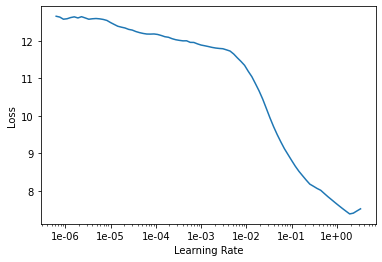

In [38]:
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.024190,0.025500,0.152608,02:29
1,0.018772,0.023012,0.147909,02:30
2,0.017833,0.019814,0.121906,02:31
3,0.012320,0.013039,0.109978,02:31
4,0.010936,0.012900,0.106251,02:30


In [0]:
learn.save('1')

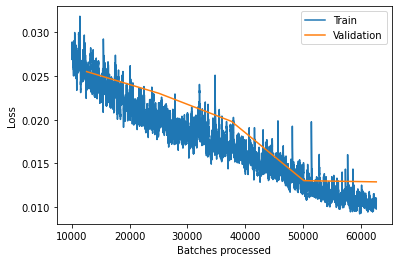

In [41]:
learn.recorder.plot_losses(skip_start=10000)

In [0]:
learn.load('1');

In [43]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.012312,0.014856,0.111871,02:30
1,0.015246,0.016705,0.111283,02:31
2,0.010924,0.015102,0.110258,02:30
3,0.010112,0.016340,0.107336,02:30
4,0.009761,0.013394,0.108842,02:30


In [44]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.010853,0.054203,0.112326,02:30
1,0.011535,0.036866,0.113708,02:30
2,0.010390,0.017400,0.111852,02:29
3,0.009208,0.013648,0.116222,02:29
4,0.009381,0.015321,0.111158,02:29


(10th place in the competition was 0.108)

\# 학습 수행 및 저장, 반복

In [45]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)

\# 러너의 학습 결과를 csv파일로 변환

Q : np.exp()는 무엇을 의미하나요?